In [ ]:
import os
import random
import ast
import re
from pathlib import Path
from typing import List, Dict, Tuple

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

from transformers import ViTModel, AutoModelForCausalLM, AutoTokenizer

In [ ]:
class Config:
    # ---- Task 1 (Order of body parts) ----
    t1_csv_path = "annotated_t4_single.csv"
    t1_image_folder = "Thermal_Images"

    # ---- Task 2 (Person counting) ----
    t2_csv_path = "T3llvip.csv"

    # Models / Checkpoints
    vit_model = "google/vit-base-patch16-224"
    llm_model = "gpt2"
    pretrained_checkpoint = "nanovlm_instruction.pt"   # optional warm-start
    new_checkpoint = "nanovlm_instruction_finetuned.pt"   # saved under out_dir

    # Splits (done PER TASK)
    train_ratio = 0.8
    random_seed = 42

    # Training hyperparams
    stage1_epochs = 8
    stage1_lr = 5e-4
    stage1_batch_size = 6

    stage2_epochs = 6
    stage2_lr = 1e-5
    stage2_batch_size = 4

    max_length = 128
    gradient_clip = 1.0

    # Generation
    max_new_tokens = 24
    temperature = 0.7
    top_k = 50
    top_p = 0.9
    repetition_penalty = 1.15

    # C3-Medium mixing controls
    mix_base_prob = 0.5     # baseline 50–50
    mix_stickiness = 0.35   # chance to repeat previous task
    mix_max_streak = 3      # cap short streaks

    # Misc
    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers = 0

    # Output files
    out_dir = "multitask_outputs"
    t1_results_csv = "t1_results.csv"
    t2_results_csv = "t2_results.csv"
    loss_plot_png = "loss_curves.png"
    acc_plot_png = "task_metrics.png"


config = Config()
os.makedirs(config.out_dir, exist_ok=True)
random.seed(config.random_seed)

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data Loaders: Task 1 (Order) and Task 2 (Counting)
def find_image_in_folder(image_folder: Path, image_name: str) -> Path | None:
    # Try exact or with common extensions
    if (image_folder / image_name).exists():
        return image_folder / image_name
    stem = Path(image_name).stem
    for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']:
        candidate = image_folder / f"{stem}{ext}"
        if candidate.exists():
            return candidate
    return None

def load_task1(csv_path: str, image_folder: str) -> List[Dict]:
    df = pd.read_csv(csv_path)
    image_folder = Path(image_folder)
    vqa = []
    skipped = 0

    q_variants = [
        "What is the order of body parts from hottest to coldest temperature?",
        "Order the body parts by temperature from hottest to coldest.",
        "List body parts from highest to lowest temperature."
    ]

    for _, row in df.iterrows():
        name = row['image_name']
        order_str = row['order']
        try:
            order_list = ast.literal_eval(order_str)
            order_list = [str(x).strip() for x in order_list]
        except Exception:
            skipped += 1
            continue

        img_path = find_image_in_folder(image_folder, name)
        if img_path is None or len(order_list) == 0:
            skipped += 1
            continue

        answer = ", ".join(order_list)
        vqa.append({
            "image": str(img_path),
            "question_variants": q_variants,
            "answer": answer,
            "meta": {"order_list": order_list}
        })

    print(f"[T1] total rows={len(df)}, valid={len(vqa)}, skipped={skipped}")
    return vqa

def load_task2(csv_path: str) -> List[Dict]:
    df = pd.read_csv(csv_path).copy()
    if 'image_path' not in df.columns or 'person_count' not in df.columns:
        raise ValueError("T2 CSV must have columns: image_path, person_count")

    df['image_path'] = df['image_path'].astype(str).str.replace('\\', '/')
    df['image_path'] = df['image_path'].str.replace('Datasets/', '', regex=False)
    df['exists'] = df['image_path'].apply(lambda p: Path(p).exists())
    missing = int((~df['exists']).sum())
    if missing > 0:
        print(f"[T2] Missing files: {missing} (they will be ignored)")
    df = df[df['exists']].copy()

    q_variants = [
        "How many people are in this image?",
        "Count the number of people in the image.",
        "What is the number of people present in the image?"
    ]

    vqa = []
    for _, row in df.iterrows():
        vqa.append({
            "image": row['image_path'],
            "question_variants": q_variants,
            "answer": str(int(row['person_count'])),
            "meta": {"count": int(row['person_count'])}
        })
    print(f"[T2] total rows={len(df)}, valid={len(vqa)}")
    return vqa

def grouped_train_test_split(items: List[Dict], key='image', train_ratio=0.8, seed=42) -> Tuple[List[Dict], List[Dict]]:
    imgs = sorted({it[key] for it in items})
    tr_imgs, te_imgs = train_test_split(imgs, train_size=train_ratio, random_state=seed)
    tr = [it for it in items if it[key] in tr_imgs]
    te = [it for it in items if it[key] in te_imgs]
    return tr, te

# Datasets
class VisionInstructDataset(Dataset):
    """
    Generic VQA-style dataset with instruction formatting.
    Returns only training-needed fields to keep batches clean.
    For test/eval we still keep meta in a side list.
    """
    def __init__(self, data: List[Dict], transform=None, keep_meta=False):
        self.data = data
        self.transform = transform
        self.keep_meta = keep_meta  # True for test sets

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img_path = Path(item["image"])
        # randomly choose from 3 variants
        q = random.choice(item["question_variants"])
        try:
            img = Image.open(img_path).convert("RGB")
            if self.transform:
                img = self.transform(img)
        except Exception:
            img = torch.zeros(3,224,224)
        finally:
            try:
                if 'img' in locals(): img.close()
            except: pass

        prompt = f"Instruction: {q}\nAnswer:"
        out = {
            "image": img,
            "prompt": prompt,
            "answer": item["answer"],
            "image_path": str(img_path),
        }
        if self.keep_meta:
            out["meta"] = item["meta"]
        return out

# Model
class NanoVLM(nn.Module):
    def __init__(self, vit_model_name, llm_model_name):
        super().__init__()
        self.vision_encoder = ViTModel.from_pretrained(vit_model_name)
        for p in self.vision_encoder.parameters():
            p.requires_grad = False
        self.vision_encoder.eval()

        self.llm = AutoModelForCausalLM.from_pretrained(
            llm_model_name,
            torch_dtype=torch.float32,
            low_cpu_mem_usage=True
        )
        for p in self.llm.parameters():
            p.requires_grad = False

        vdim = self.vision_encoder.config.hidden_size
        tdim = self.llm.config.hidden_size
        self.vision_projection = nn.Sequential(
            nn.Linear(vdim, tdim*2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(tdim*2, tdim),
            nn.LayerNorm(tdim),
            nn.Dropout(0.05),
        )

    def freeze_llm(self):
        for p in self.llm.parameters():
            p.requires_grad = False

    def unfreeze_llm_decoder(self, num_layers=4):
        if hasattr(self.llm, 'transformer'):
            layers = self.llm.transformer.h
            total = len(layers)
            for i in range(total - num_layers, total):
                for p in layers[i].parameters():
                    p.requires_grad = True
            for p in self.llm.lm_head.parameters():
                p.requires_grad = True

    def forward(self, pixel_values, input_ids, attention_mask=None, labels=None):
        B = pixel_values.size(0)
        with torch.no_grad():
            v_out = self.vision_encoder(pixel_values=pixel_values)
            v_feat = v_out.last_hidden_state
        v_emb = self.vision_projection(v_feat)

        t_emb = self.llm.get_input_embeddings()(input_ids)
        combo = torch.cat([v_emb, t_emb], dim=1)

        n_v = v_emb.size(1)
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids, dtype=torch.long)
        v_attn = torch.ones(B, n_v, dtype=torch.long, device=attention_mask.device)
        combo_attn = torch.cat([v_attn, attention_mask], dim=1)

        combo_labels = None
        if labels is not None:
            v_labels = torch.full((B, n_v), -100, dtype=torch.long, device=labels.device)
            combo_labels = torch.cat([v_labels, labels], dim=1)

        out = self.llm(
            inputs_embeds=combo,
            attention_mask=combo_attn,
            labels=combo_labels,
            return_dict=True
        )
        return out

    @torch.no_grad()
    def generate(self, pixel_values, input_ids, max_new_tokens=24, temperature=0.7, top_k=50, top_p=0.9, repetition_penalty=1.15):
        self.eval()
        v_out = self.vision_encoder(pixel_values=pixel_values)
        v_emb = self.vision_projection(v_out.last_hidden_state)

        generated = input_ids[0].tolist()
        for _ in range(max_new_tokens):
            cur_ids = torch.tensor([generated], device=pixel_values.device)
            t_emb = self.llm.get_input_embeddings()(cur_ids)
            combo = torch.cat([v_emb, t_emb], dim=1)
            logits = self.llm(inputs_embeds=combo, return_dict=True).logits[0, -1, :].clone()

            # repetition penalty
            for tok in set(generated):
                if logits[tok] < 0:
                    logits[tok] *= repetition_penalty
                else:
                    logits[tok] /= repetition_penalty

            logits = logits / temperature
            if top_k > 0:
                kth = torch.topk(logits, top_k)[0][..., -1, None]
                logits[logits < kth] = float('-inf')
            if top_p < 1.0:
                sorted_logits, sorted_idx = torch.sort(logits, descending=True)
                probs = torch.softmax(sorted_logits, dim=-1)
                cum = torch.cumsum(probs, dim=-1)
                mask = cum > top_p
                mask[1:] = mask[:-1].clone()
                mask[0] = 0
                remove = sorted_idx[mask]
                logits[remove] = float('-inf')

            probs = torch.softmax(logits, dim=-1)
            nxt = torch.multinomial(probs, 1).item()
            if nxt == self.llm.config.eos_token_id:
                break
            generated.append(nxt)
        return torch.tensor([generated], device=pixel_values.device)

# Utilities
def build_tokenizer():
    tok = AutoTokenizer.from_pretrained(config.llm_model)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    return tok

def mask_labels_for_prefix(tokenizer, prompts: List[str], input_ids: torch.Tensor) -> torch.Tensor:
    labels = input_ids.clone()
    for i, p in enumerate(prompts):
        prefix_tokens = tokenizer(p, add_special_tokens=False).input_ids
        labels[i, :len(prefix_tokens)] = -100
    return labels

def normalize_answer(ans: str) -> List[str]:
    a = ans.lower().strip()
    a = a.replace(',', ' ').replace('.', ' ')
    parts = [p.strip() for p in a.split() if p.strip()]
    return parts

def extract_first_int(s: str):
    nums = re.findall(r"-?\d+", s)
    return int(nums[0]) if nums else None

# Collate 
def collate_fn(batch):
    images = torch.stack([b["image"] for b in batch])
    prompts = [b["prompt"] for b in batch]
    answers = [b["answer"] for b in batch]
    paths = [b["image_path"] for b in batch]
    metas = [b.get("meta") for b in batch]  # may be None in train
    return {
        "image": images,
        "prompt": prompts,
        "answer": answers,
        "image_path": paths,
        "meta": metas
    }

# C3-MEDIUM Mixing: schedule generator
def make_mixed_schedule(n_steps, stickiness=0.35, max_streak=3):
    """
    Returns a list like ["T1","T2","T1","T1","T2", ...]
    - baseline 50–50
    - chance 'stickiness' to repeat same task
    - streaks capped at max_streak
    """
    seq = []
    prev = None
    streak = 0
    for _ in range(n_steps):
        if prev is None:
            cur = "T1" if random.random() < 0.5 else "T2"
        else:
            if streak >= max_streak:
                cur = "T1" if prev == "T2" else "T2"
            else:
                if random.random() < stickiness:
                    cur = prev
                else:
                    cur = "T1" if prev == "T2" else "T2"
        seq.append(cur)
        if cur == prev:
            streak += 1
        else:
            streak = 1
        prev = cur
    return seq

# Training (multi-task mixed C3)
def train_multitask_stage(model, tok, dl_t1, dl_t2, lr, epochs, stage_name, hist_store:dict):
    print("\n" + "="*70)
    print(f"{stage_name.upper()}  (C3-MEDIUM mixed)")
    print("="*70)

    # which params to train?
    if "stage1" in stage_name.lower():
        model.freeze_llm()
        params = model.vision_projection.parameters()
    else:
        model.unfreeze_llm_decoder(num_layers=4)
        params = [p for p in model.parameters() if p.requires_grad]

    opt = torch.optim.AdamW(params, lr=lr, weight_decay=0.01)

    # we aim ~equal number of steps from both loaders
    steps_per_epoch = (len(dl_t1) + len(dl_t2))
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs * steps_per_epoch)

    model.train()
    for ep in range(1, epochs+1):
        loss_t1_epoch, loss_t2_epoch = 0.0, 0.0
        it1 = iter(dl_t1)
        it2 = iter(dl_t2)
        schedule = make_mixed_schedule(
            n_steps=steps_per_epoch,
            stickiness=config.mix_stickiness,
            max_streak=config.mix_max_streak
        )
        pbar = tqdm(schedule, desc=f"Epoch {ep}/{epochs}")

        for step_task in pbar:
            if step_task == "T1":
                try:
                    b = next(it1)
                except StopIteration:
                    # if exhausted, try the other task
                    try:
                        b = next(it2); step_task = "T2"
                    except StopIteration:
                        break
            else:  # "T2"
                try:
                    b = next(it2)
                except StopIteration:
                    try:
                        b = next(it1); step_task = "T1"
                    except StopIteration:
                        break

            pv = b["image"].to(config.device)
            prompts = b["prompt"]
            answers = b["answer"]

            texts = [f"{p} {a}" for p,a in zip(prompts, answers)]
            enc = tok(texts, return_tensors="pt", padding=True, truncation=True, max_length=config.max_length).to(config.device)
            input_ids = enc.input_ids
            attn = enc.attention_mask
            labels = mask_labels_for_prefix(tok, prompts, input_ids)

            out = model(pv, input_ids, attn, labels)
            loss = out.loss

            opt.zero_grad()
            loss.backward()
            # clip the currently active params
            if isinstance(params, list):
                torch.nn.utils.clip_grad_norm_(params, config.gradient_clip)
            else:
                torch.nn.utils.clip_grad_norm_(list(params), config.gradient_clip)
            opt.step()
            sched.step()

            if step_task == "T1":
                loss_t1_epoch += float(loss.detach().cpu())
            else:
                loss_t2_epoch += float(loss.detach().cpu())

            avg_t1 = loss_t1_epoch / max(1, len(dl_t1))
            avg_t2 = loss_t2_epoch / max(1, len(dl_t2))
            pbar.set_postfix({"t1_loss": f"{avg_t1:.4f}", "t2_loss": f"{avg_t2:.4f}"})

        loss_t1_epoch /= max(1, len(dl_t1))
        loss_t2_epoch /= max(1, len(dl_t2))
        print(f"Epoch {ep} | T1 loss: {loss_t1_epoch:.4f} | T2 loss: {loss_t2_epoch:.4f}")

        hist_store.setdefault(stage_name, {"t1": [], "t2": []})
        hist_store[stage_name]["t1"].append(loss_t1_epoch)
        hist_store[stage_name]["t2"].append(loss_t2_epoch)

# Inference & Evaluation
@torch.no_grad()
def generate_answer(model, tok, image_path: str, prompt_prefix: str) -> str:
    img = Image.open(image_path).convert("RGB")
    pv = transform(img).unsqueeze(0).to(config.device)
    img.close()
    enc = tok(prompt_prefix, return_tensors="pt").to(config.device)
    gen_ids = model.generate(
        pv, enc.input_ids,
        max_new_tokens=config.max_new_tokens,
        temperature=config.temperature,
        top_k=config.top_k,
        top_p=config.top_p,
        repetition_penalty=config.repetition_penalty
    )
    text = tok.decode(gen_ids[0], skip_special_tokens=True)
    return text.split("Answer:")[-1].strip()

def t1_match(order_list: List[str], predicted: str) -> str:
    exp = [p.lower().strip() for p in order_list]
    got = normalize_answer(predicted)
    if got == exp:
        return "exact"
    if set(got) == set(exp):
        return "partial"
    m = sum(1 for e in exp if e in got)
    return "partial" if m >= max(1, len(exp)//2) else "wrong"

def evaluate_t1(model, tok, test_items: List[Dict]) -> Tuple[pd.DataFrame, Dict]:
    results = []
    exact=partial=wrong=err = 0
    for it in tqdm(test_items, desc="[T1] Evaluating"):
        q = random.choice(it["question_variants"])
        prompt = f"Instruction: {q}\nAnswer:"
        try:
            pred = generate_answer(model, tok, it['image'], prompt)
            status = t1_match(it["meta"]["order_list"], pred)
        except Exception:
            pred = "ERROR"
            status = "error"

        if status=="exact": exact+=1
        elif status=="partial": partial+=1
        elif status=="wrong": wrong+=1
        else: err+=1

        results.append({
            "image": Path(it["image"]).name,
            "expected": ", ".join(it["meta"]["order_list"]),
            "predicted": pred,
            "status": status
        })

    total = len(results)
    metrics = {
        "exact": exact/total if total else 0.0,
        "partial": partial/total if total else 0.0,
        "wrong": wrong/total if total else 0.0,
        "error": err/total if total else 0.0,
        "combined": (exact+partial)/total if total else 0.0,
        "n_samples": total
    }
    return pd.DataFrame(results), metrics

def evaluate_t2(model, tok, test_items: List[Dict]) -> Tuple[pd.DataFrame, Dict]:
    rows = []
    exact=within1=0
    mae_sum = 0.0
    mse_sum = 0.0
    for it in tqdm(test_items, desc="[T2] Evaluating"):
        q = random.choice(it["question_variants"])
        prompt = f"Instruction: {q}\nAnswer:"
        try:
            pred_txt = generate_answer(model, tok, it['image'], prompt)
            pred = extract_first_int(pred_txt)
            if pred is None: pred = -99999
        except Exception:
            pred_txt = "ERROR"
            pred = -99999

        gt = it["meta"]["count"]
        ex = (pred == gt)
        w1 = (abs(pred-gt) <= 1) if pred > -99999 else False
        err = abs(pred-gt) if pred > -99999 else 0
        sqe = (pred-gt)**2 if pred > -99999 else 0

        exact += int(ex)
        within1 += int(w1)
        mae_sum += err
        mse_sum += sqe

        rows.append({
            "image": Path(it["image"]).name,
            "expected": gt,
            "predicted": pred if pred > -99999 else None,
            "raw_answer": pred_txt
        })

    total = len(rows)
    metrics = {
        "exact": exact/total if total else 0.0,
        "within_1": within1/total if total else 0.0,
        "mae": mae_sum/total if total else 0.0,
        "mse": mse_sum/total if total else 0.0,
        "n_samples": total
    }
    return pd.DataFrame(rows), metrics

# Plotting
def plot_losses(history: Dict, save_path: str):
    plt.figure()
    if "stage1" in history:
        x = list(range(1, len(history["stage1"]["t1"])+1))
        plt.plot(x, history["stage1"]["t1"], label="T1 loss (stage1)")
        plt.plot(x, history["stage1"]["t2"], label="T2 loss (stage1)")
    if "stage2" in history:
        offset = len(history.get("stage1", {}).get("t1", []))
        x2 = [offset + i for i in range(1, len(history["stage2"]["t1"])+1)]
        plt.plot(x2, history["stage2"]["t1"], label="T1 loss (stage2)")
        plt.plot(x2, history["stage2"]["t2"], label="T2 loss (stage2)")
    plt.xlabel("Epochs (cumulative)")
    plt.ylabel("Loss")
    plt.title("Training Loss (Multi-task C3)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def plot_task_metrics(t1_metrics: Dict, t2_metrics: Dict, save_path: str):
    plt.figure()
    names = ["T1 exact", "T1 partial", "T1 combined", "T2 exact", "T2 within±1"]
    vals = [
        t1_metrics.get("exact",0.0),
        t1_metrics.get("partial",0.0),
        t1_metrics.get("combined",0.0),
        t2_metrics.get("exact",0.0),
        t2_metrics.get("within_1",0.0)
    ]
    plt.bar(names, vals)
    plt.ylim(0,1.0)
    plt.title("Task Accuracies")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# Main
def main():
    print("="*70)
    print("NanoVLM Multi-Task (T1: Order | T2: Person Count) — C3-Medium Mix")
    print("="*70)
    print(f"Device: {config.device}\n")

    # ----- Load data per task -----
    t1_all = load_task1(config.t1_csv_path, config.t1_image_folder)
    t2_all = load_task2(config.t2_csv_path)

    t1_train, t1_test = grouped_train_test_split(t1_all, key='image', train_ratio=config.train_ratio, seed=config.random_seed)
    t2_train, t2_test = grouped_train_test_split(t2_all, key='image', train_ratio=config.train_ratio, seed=config.random_seed)

    print(f"[T1] Train={len(t1_train)}, Test={len(t1_test)}")
    print(f"[T2] Train={len(t2_train)}, Test={len(t2_test)}\n")

    # ----- Tokenizer / Model -----
    tok = build_tokenizer()
    model = NanoVLM(config.vit_model, config.llm_model).to(config.device)

    # Optional warm-start
    if Path(config.pretrained_checkpoint).exists():
        print(f"🔄 Loading checkpoint: {config.pretrained_checkpoint}")
        ckpt = torch.load(config.pretrained_checkpoint, map_location=config.device)
        try:
            model.load_state_dict(ckpt['model_state_dict'], strict=False)
            print("✓ Pretrained weights loaded (non-strict).")
        except Exception as e:
            print(f"⚠ Could not load checkpoint strictly: {e}")

    # ----- Datasets / Loaders -----
    ds_t1_train = VisionInstructDataset(t1_train, transform=transform, keep_meta=False)
    ds_t2_train = VisionInstructDataset(t2_train, transform=transform, keep_meta=False)

    dl_t1_s1 = DataLoader(ds_t1_train, batch_size=config.stage1_batch_size, shuffle=True,
                          num_workers=config.num_workers, collate_fn=collate_fn)
    dl_t2_s1 = DataLoader(ds_t2_train, batch_size=config.stage1_batch_size, shuffle=True,
                          num_workers=config.num_workers, collate_fn=collate_fn)

    ds_t1_test = VisionInstructDataset(t1_test, transform=transform, keep_meta=True)
    ds_t2_test = VisionInstructDataset(t2_test, transform=transform, keep_meta=True)

    # ----- Train Stage 1 -----
    history = {}
    train_multitask_stage(model, tok, dl_t1_s1, dl_t2_s1, lr=config.stage1_lr, epochs=config.stage1_epochs, stage_name="stage1", hist_store=history)

    # ----- Train Stage 2 -----
    dl_t1_s2 = DataLoader(ds_t1_train, batch_size=config.stage2_batch_size, shuffle=True,
                          num_workers=config.num_workers, collate_fn=collate_fn)
    dl_t2_s2 = DataLoader(ds_t2_train, batch_size=config.stage2_batch_size, shuffle=True,
                          num_workers=config.num_workers, collate_fn=collate_fn)
    train_multitask_stage(model, tok, dl_t1_s2, dl_t2_s2, lr=config.stage2_lr, epochs=config.stage2_epochs, stage_name="stage2", hist_store=history)

    # ----- Save model -----
    save_path = os.path.join(config.out_dir, config.new_checkpoint)
    torch.save({
        "model_state_dict": model.state_dict(),
        "config": config.__dict__
    }, save_path)
    print(f"\n💾 Saved fine-tuned model to {save_path}")

    # ----- Evaluate -----
    print("\nEvaluating...")
    # For evaluation, use the original test item dicts (they contain meta)
    t1_df, t1_metrics = evaluate_t1(model, tok, t1_test)
    t2_df, t2_metrics = evaluate_t2(model, tok, t2_test)

    t1_csv = os.path.join(config.out_dir, config.t1_results_csv)
    t2_csv = os.path.join(config.out_dir, config.t2_results_csv)
    t1_df.to_csv(t1_csv, index=False)
    t2_df.to_csv(t2_csv, index=False)

    print("\n" + "="*70)
    print("METRICS")
    print("="*70)
    print(f"[T1] exact={t1_metrics['exact']*100:.1f}%, partial={t1_metrics['partial']*100:.1f}%, combined={t1_metrics['combined']*100:.1f}% | n={t1_metrics['n_samples']}")
    print(f"[T2] exact={t2_metrics['exact']*100:.1f}%, within±1={t2_metrics['within_1']*100:.1f}% | MAE={t2_metrics['mae']:.3f}, MSE={t2_metrics['mse']:.3f} | n={t2_metrics['n_samples']}")
    print("="*70)
    print(f"Results saved:\n  - {t1_csv}\n  - {t2_csv}")

    loss_png = os.path.join(config.out_dir, config.loss_plot_png)
    plot_losses(history, loss_png)
    acc_png = os.path.join(config.out_dir, config.acc_plot_png)
    plot_task_metrics(t1_metrics, t2_metrics, acc_png)
    print(f"Charts saved:\n  - {loss_png}\n  - {acc_png}")

    print("\nDone ✅")

if __name__ == "__main__":
    main()


NanoVLM Multi-Task (T1: Order | T2: Person Count) — C3-Medium Mix
Device: cuda

[T1] total rows=144, valid=144, skipped=0
[T2] Missing files: 5286 (they will be ignored)
[T2] total rows=4714, valid=4714
[T1] Train=115, Test=29
[T2] Train=3771, Test=943



Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



STAGE1  (C3-MEDIUM mixed)


Epoch 1/8: 100%|██████████| 649/649 [06:53<00:00,  1.57it/s, t1_loss=2.8075, t2_loss=0.7598]


Epoch 1 | T1 loss: 2.8075 | T2 loss: 0.7598


Epoch 2/8: 100%|██████████| 649/649 [06:44<00:00,  1.60it/s, t1_loss=1.4549, t2_loss=0.5854]


Epoch 2 | T1 loss: 1.4549 | T2 loss: 0.5854


Epoch 3/8: 100%|██████████| 649/649 [06:45<00:00,  1.60it/s, t1_loss=0.9204, t2_loss=0.5307]


Epoch 3 | T1 loss: 0.9204 | T2 loss: 0.5307


Epoch 4/8: 100%|██████████| 649/649 [06:44<00:00,  1.60it/s, t1_loss=0.7413, t2_loss=0.4708]


Epoch 4 | T1 loss: 0.7413 | T2 loss: 0.4708


Epoch 5/8: 100%|██████████| 649/649 [10:56<00:00,  1.01s/it, t1_loss=0.6552, t2_loss=0.4199]


Epoch 5 | T1 loss: 0.6552 | T2 loss: 0.4199


Epoch 6/8: 100%|██████████| 649/649 [11:08<00:00,  1.03s/it, t1_loss=0.5662, t2_loss=0.3399]


Epoch 6 | T1 loss: 0.5662 | T2 loss: 0.3399


Epoch 7/8: 100%|██████████| 649/649 [11:13<00:00,  1.04s/it, t1_loss=0.5628, t2_loss=0.2644]


Epoch 7 | T1 loss: 0.5628 | T2 loss: 0.2644


Epoch 8/8: 100%|██████████| 649/649 [11:18<00:00,  1.05s/it, t1_loss=0.4645, t2_loss=0.2148]


Epoch 8 | T1 loss: 0.4645 | T2 loss: 0.2148

STAGE2  (C3-MEDIUM mixed)


Epoch 1/6: 100%|██████████| 972/972 [11:52<00:00,  1.36it/s, t1_loss=0.4417, t2_loss=0.2562]


Epoch 1 | T1 loss: 0.4417 | T2 loss: 0.2562


Epoch 2/6: 100%|██████████| 972/972 [11:48<00:00,  1.37it/s, t1_loss=0.4505, t2_loss=0.2236]


Epoch 2 | T1 loss: 0.4505 | T2 loss: 0.2236


Epoch 3/6: 100%|██████████| 972/972 [11:48<00:00,  1.37it/s, t1_loss=0.4195, t2_loss=0.2036]


Epoch 3 | T1 loss: 0.4195 | T2 loss: 0.2036


Epoch 4/6: 100%|██████████| 972/972 [11:47<00:00,  1.37it/s, t1_loss=0.3336, t2_loss=0.1945]


Epoch 4 | T1 loss: 0.3336 | T2 loss: 0.1945


Epoch 5/6: 100%|██████████| 972/972 [11:52<00:00,  1.36it/s, t1_loss=0.3505, t2_loss=0.1674]


Epoch 5 | T1 loss: 0.3505 | T2 loss: 0.1674


Epoch 6/6: 100%|██████████| 972/972 [11:57<00:00,  1.35it/s, t1_loss=0.3532, t2_loss=0.1698]


Epoch 6 | T1 loss: 0.3532 | T2 loss: 0.1698

💾 Saved fine-tuned model to multitask_outputs/nanovlm_instruction_finetuned.pt

Evaluating...


[T2] Evaluating: 100%|██████████| 943/943 [02:51<00:00,  5.49it/s]



METRICS
[T1] exact=34.5%, partial=65.5%, combined=100.0% | n=29
[T2] exact=54.0%, within±1=92.7% | MAE=0.544, MSE=0.733 | n=943
Results saved:
  - multitask_outputs/t1_results.csv
  - multitask_outputs/t2_results.csv
Charts saved:
  - multitask_outputs/loss_curves.png
  - multitask_outputs/task_metrics.png

Done ✅


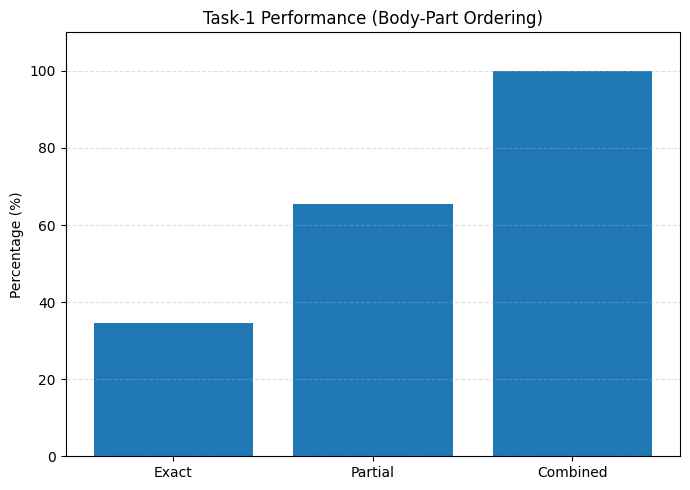

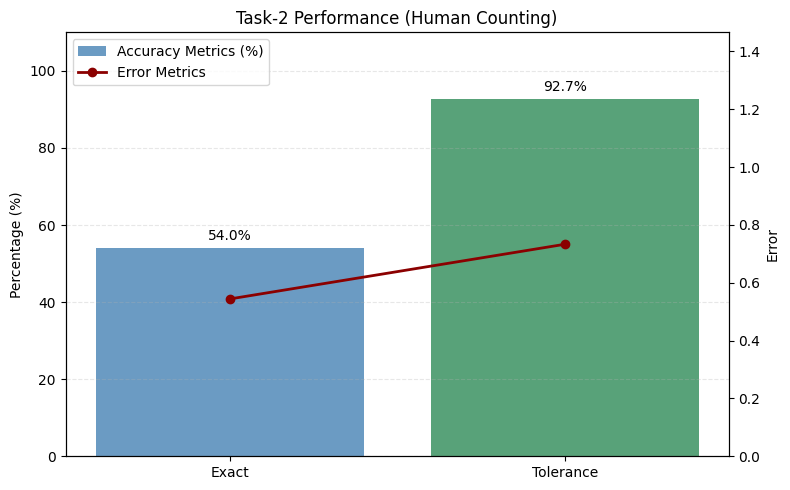

In [ ]:
import matplotlib.pyplot as plt

T1_exact = 34.5
T1_partial = 65.5
T1_combined = 100.0

T2_exact = 54.0
T2_tolerance = 92.7    
T2_mae = 0.544
T2_mse = 0.733

plt.figure(figsize=(7, 5))
plt.bar(["Exact", "Partial", "Combined"],
        [T1_exact, T1_partial, T1_combined])

plt.title("Task-1 Performance (Body-Part Ordering)")
plt.ylabel("Percentage (%)")
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig("task1_bar.png", dpi=300)
plt.show()

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.bar(["Exact", "Tolerance"],
        [T2_exact, T2_tolerance],
        color=["steelblue", "seagreen"],
        alpha=0.8,
        label="Accuracy Metrics (%)")

ax1.set_ylabel("Percentage (%)")
ax1.set_ylim(0, 110)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

for i, v in enumerate([T2_exact, T2_tolerance]):
    ax1.text(i, v + 2, f"{v:.1f}%", ha='center', fontsize=10)

ax2 = ax1.twinx()
ax2.plot(["Exact", "Tolerance"], 
         [T2_mae, T2_mse],
         marker="o",
         linewidth=2,
         color="darkred",
         label="Error Metrics")

ax2.set_ylabel("Error")
ax2.set_ylim(0, max(T2_mae, T2_mse) * 2)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left")

plt.title("Task-2 Performance (Human Counting)")
plt.tight_layout()
plt.savefig("task2_metrics.png", dpi=300)
plt.show()


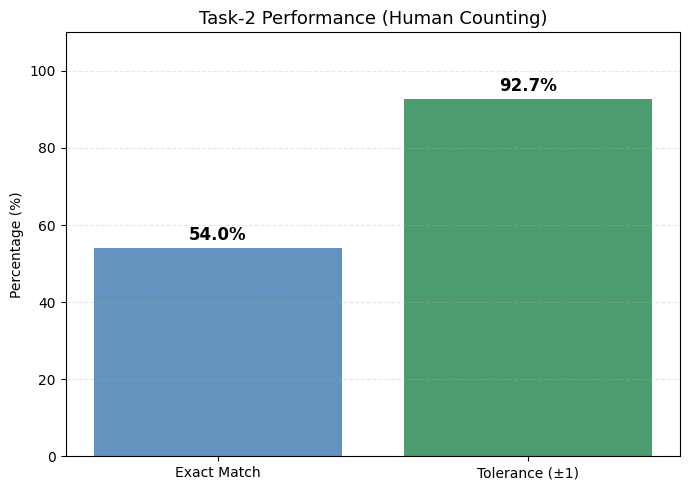

In [ ]:
import matplotlib.pyplot as plt


T2_exact = 54.0
T2_tolerance = 92.7  

plt.figure(figsize=(7, 5))

labels = ["Exact Match", "Tolerance (±1)"]
values = [T2_exact, T2_tolerance]
colors = ["steelblue", "seagreen"]

plt.bar(labels, values, color=colors, alpha=0.85)

for i, v in enumerate(values):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontsize=12, fontweight='bold')

plt.title("Task-2 Performance (Human Counting)", fontsize=13)
plt.ylabel("Percentage (%)")
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig("task2_accuracy.png", dpi=300)
plt.show()


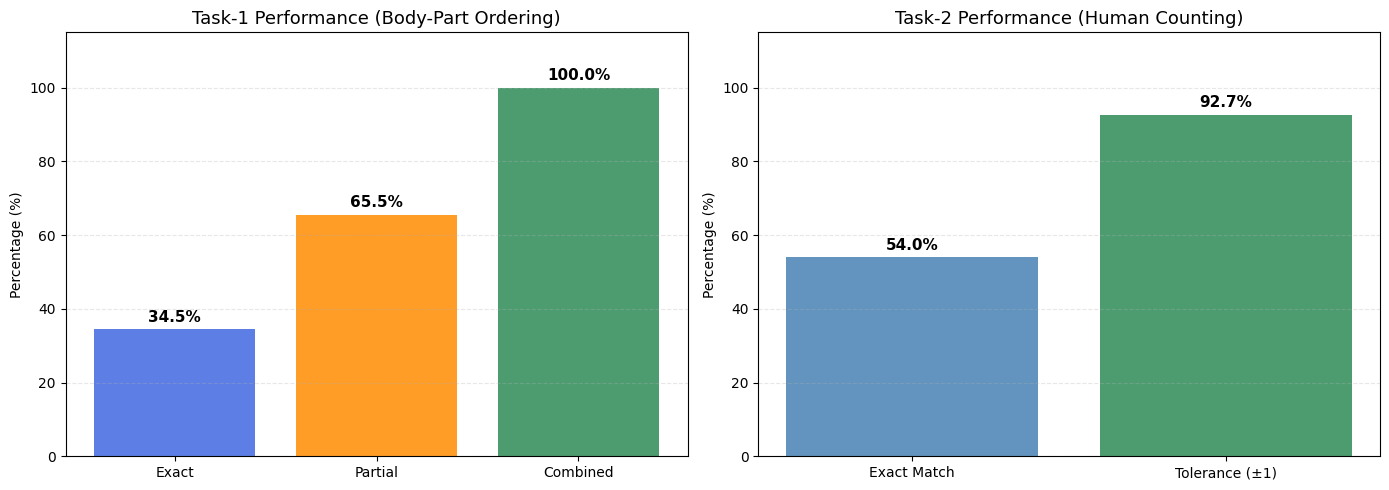

In [ ]:
import matplotlib.pyplot as plt

T1_exact = 34.5
T1_partial = 65.5
T1_combined = 100.0

T2_exact = 54.0
T2_tolerance = 92.7

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]

labels1 = ["Exact", "Partial", "Combined"]
values1 = [T1_exact, T1_partial, T1_combined]

ax1.bar(labels1, values1, color=["royalblue", "darkorange", "seagreen"], alpha=0.85)

for i, v in enumerate(values1):
    ax1.text(i, v + 2, f"{v:.1f}%", ha='center', fontsize=11, fontweight='bold')

ax1.set_title("Task-1 Performance (Body-Part Ordering)", fontsize=13)
ax1.set_ylabel("Percentage (%)")
ax1.set_ylim(0, 115)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

ax2 = axes[1]

labels2 = ["Exact Match", "Tolerance (±1)"]
values2 = [T2_exact, T2_tolerance]

ax2.bar(labels2, values2, color=["steelblue", "seagreen"], alpha=0.85)

for i, v in enumerate(values2):
    ax2.text(i, v + 2, f"{v:.1f}%", ha='center', fontsize=11, fontweight='bold')

ax2.set_title("Task-2 Performance (Human Counting)", fontsize=13)
ax2.set_ylabel("Percentage (%)")
ax2.set_ylim(0, 115)
ax2.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig("combined_task1_task2.png", dpi=300)
plt.show()
